In [1]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy
import skimage
from skimage.transform import rescale, resize, downscale_local_mean
from scipy import stats

In [3]:
from matplotlib.colors import ListedColormap

In [4]:
my_cmap = ListedColormap(sns.light_palette((210, 90, 60), input="husl", n_colors=50))
my_cmap = ListedColormap(sns.diverging_palette(220, 20, n=50))
my_cmap = ListedColormap(sns.color_palette("RdBu_r", 50))
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

## 2D

The dynamics is defined by the following ODE:
$$\frac{dx}{dt} = \frac{\sqrt{2}}{p(x|y)} = \sqrt{2}\frac{p(y)}{p(x,y)},$$
$$\frac{dy}{dt} = \frac{1}{p(y|x)} = \frac{p(x)}{p(x,y)}.$$
Note that the $\sqrt{2}$ is essential. It guarantees the ergodicity of the system.

In [5]:
class DGibbs:
    def __init__(self, probs, state0, suzuki=False):
        self.suzuki = suzuki
        self.probs = probs
        self.margin_x = np.sum(probs, axis=0)
        self.margin_y = np.sum(probs, axis=1)
        self.current_state = state0.copy()
        self.x = state0
        self.v = np.zeros(2)
        self.v[0] = self.margin_x[self.current_state[1]]
        if not self.suzuki:
            self.v[0] *= np.sqrt(2)
        self.v[1] = self.margin_y[self.current_state[0]]
        self.v = self.v/probs[self.current_state[0], self.current_state[1]]
        self.dist_to_border = np.ones([2])
        self.samples = []
        self.weights = []
        self.trajectory = [self.x.copy()]
        
    def iterate(self):
        # evaluate time
        time_until_border = self.dist_to_border/self.v
        iterate_time = np.min(time_until_border)
        change_dim = np.argmin(time_until_border)
        # update coordinates
        self.x = (self.x + self.v*iterate_time) % probs.shape
        self.x[change_dim] = (self.current_state[change_dim]+1) % probs.shape[change_dim]
        self.dist_to_border = self.dist_to_border - self.v*iterate_time
        self.dist_to_border[change_dim] = 1.0
        # put into samples
        self.samples.append(self.current_state.copy())
        self.weights.append(iterate_time)
        self.trajectory.append(self.x.copy())
        # update state
        self.current_state[change_dim] = (self.current_state[change_dim]+1) % probs.shape[change_dim]
        self.v[0] = self.margin_x[self.current_state[1]]
        if not self.suzuki:
            self.v[0] *= np.sqrt(2)
        self.v[1] = self.margin_y[self.current_state[0]]
        self.v = self.v/probs[self.current_state[0], self.current_state[1]]

class Gibbs:
    def __init__(self, probs, state0):
        self.probs = probs
        self.margin_x = np.sum(probs, axis=0)
        self.margin_y = np.sum(probs, axis=1)
        self.state = state0.copy()
        self.change_dim = 0
        self.samples = []
        self.weights = []
        
    def iterate(self):
        keep_dim = (self.change_dim + 1) % 2
        cond_probability = np.take(probs, indices=self.state[keep_dim], axis=keep_dim)
        cond_probability /= np.sum(cond_probability)
        # sample
        one_hot_sample = np.random.multinomial(1, cond_probability)
        self.state[self.change_dim] = np.nonzero(one_hot_sample)[0]
        # put into samples
        self.samples.append(self.state.copy())
        self.weights.append(1.0)
        # update state
        self.change_dim = (self.change_dim + 1) % 2

### target distribution

In [6]:
def plot_target(probs):
    plt.imshow(probs, origin='lower', cmap=my_cmap)
#     plt.xticks(np.arange(probs.shape[1])-0.5, labels=np.arange(probs.shape[1]))
#     plt.yticks(np.arange(probs.shape[0])-0.5, labels=np.arange(probs.shape[0]))
    plt.box(False)
#     plt.grid(zorder=0)

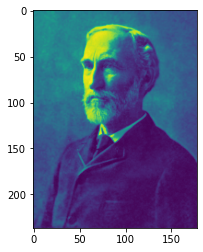

In [7]:
img = matplotlib.image.imread('portrait.jpg')
img = rescale(img, 0.2)
img = np.sum(img, axis=2)
img = img/np.sum(img)
probs = img
plt.imshow(img)
plt.show()

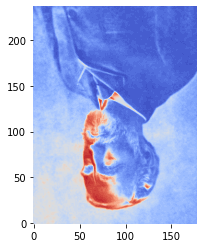

In [8]:
plot_target(probs)
plt.show()

In [9]:
sampler_d_gibbs = DGibbs(probs, np.array([0,0]))
sampler_s_gibbs = DGibbs(probs, np.array([0,0]), suzuki=True)
sampler_gibbs = Gibbs(probs, np.array([0,0]))

In [10]:
def get_hist(sampler, n):
    for _ in range(int(n)):
        sampler.iterate()
    samples = np.array(sampler.samples)
    weights = np.array(sampler.weights)
    weights /= np.sum(weights)
    approx_hist, grid_x, grid_y = np.histogram2d(samples[:,0], samples[:,1], 
                                                 bins=sampler.probs.shape, weights=weights)
    return approx_hist

In [11]:
hist_d_gibbs = get_hist(sampler_d_gibbs, 2*10**5)
hist_s_gibbs = get_hist(sampler_s_gibbs, 2*10**5)
hist_gibbs = get_hist(sampler_gibbs, 2*10**5)
hist_multinomial = np.random.multinomial(2*10**5, probs.flatten()).reshape(probs.shape)

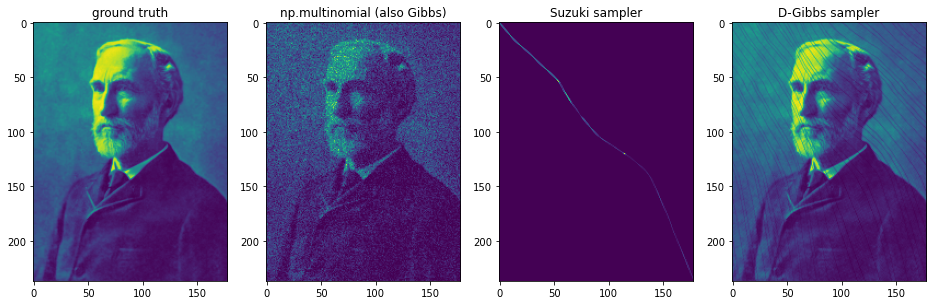

In [15]:
figsize(16,6)
plt.subplot(141)
plt.imshow(probs)
plt.title('ground truth')
plt.subplot(142)
plt.imshow(hist_multinomial)
plt.title('np.multinomial (also Gibbs)')
plt.subplot(143)
plt.imshow(hist_s_gibbs)
plt.title('Suzuki sampler')
plt.subplot(144)
plt.imshow(hist_d_gibbs)
plt.title('D-Gibbs sampler')
plt.show()

### 100 iterations (samples)

In [13]:
def plot_trajectory(trajectory):
    trajectory = trajectory-0.5
    parts = []
    part_start = 0
    for i in range(trajectory.shape[1]-1):
        if np.sum((trajectory[:,i]-trajectory[:,i+1])**2) > 2:
            next_point = trajectory[:,i+1].copy()
            tear_dim_mask = np.abs(trajectory[:,i]-trajectory[:,i+1]) > 1
            next_point = (next_point*(1-tear_dim_mask) + tear_dim_mask*(np.array(probs.shape)-0.5))[:,np.newaxis]
            parts.append(np.hstack([trajectory[:,part_start:i+1],next_point]))
            part_start = i+1
    parts.append(trajectory[:,part_start:])
    for part in parts:
        plt.plot(part[1], part[0], c='black')
        plt.scatter(part[1], part[0], c='black', s=20, zorder=2)

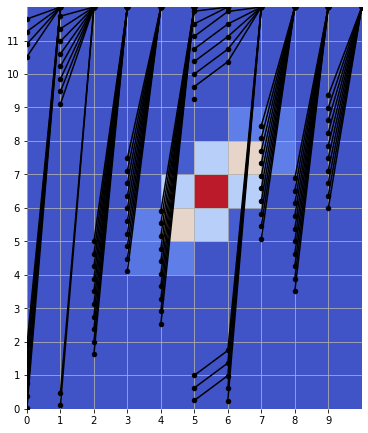

In [14]:
figsize(6,8)
plot_target(probs)
plot_trajectory(np.stack(sampler.trajectory, axis=1))
plt.show()

### convergence

In [25]:
def errors_estimate(probs, n_iterates, n_tries):
    errors = np.zeros([n_tries, n_iterates])
    for try_id in range(n_tries):
        x0 = np.floor(np.random.uniform(size=2)*probs.shape).astype(int)
        sampler = CGibbs(probs, x0)
        for _ in range(n_iterates):
            sampler.iterate()
        samples = np.stack(sampler.samples, axis=0)
        weights = np.stack(sampler.weights,axis=0)
        mean_estimates = np.cumsum(samples*weights[:,np.newaxis], axis=0)
        mean_estimates /= np.cumsum(weights[:,np.newaxis], axis=0)
        errors[try_id, :] = np.sqrt(np.sum((mean_estimates-gt_mean)**2, axis=1))
    return errors

In [26]:
n_tries = 100
n_iterates = 10000
gt_mean = np.sum(probs[:,:,np.newaxis]*np.stack([x_grid,y_grid], axis=2), axis=(0,1))[::-1]
errors = errors_estimate(probs, n_iterates, n_tries)

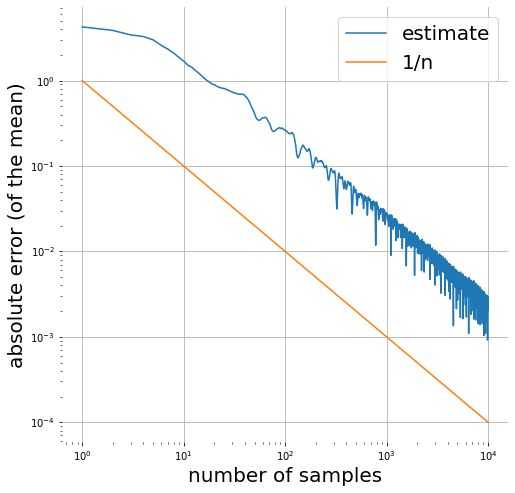

In [27]:
figsize(8,8)
plt.plot(np.arange(1,n_iterates+1), np.mean(errors, axis=0), label='estimate')
plt.plot(np.arange(1,n_iterates+1),1/np.arange(1,n_iterates+1), label='1/n')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of samples', size=20)
plt.ylabel('absolute error (of the mean)', size=20)
plt.legend(fontsize=20)
plt.grid()
plt.box(False)
plt.show()

### target distribution

Now let's move it aside to break the symmetry

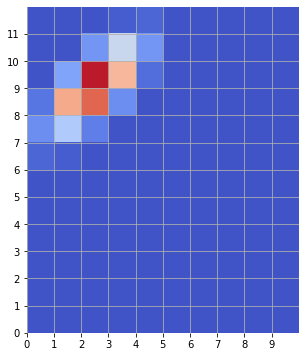

In [76]:
m,n = 10,12
x_grid,y_grid = np.arange(m),np.arange(n)
x_grid,y_grid = np.meshgrid(x_grid,y_grid)
probs = stats.multivariate_normal.pdf(np.stack([x_grid,y_grid], axis=2), 
                                          mean = [m/5,n/1.4], cov=[[1.,0.7],[0.7,1.]])
probs /= np.sum(probs)
figsize(6,6)
plot_target(probs)
plt.show()

In [77]:
sampler = CGibbs(probs, np.array([1,5]))

In [78]:
for _ in range(100):
    sampler.iterate()

### 100 iterations (samples)

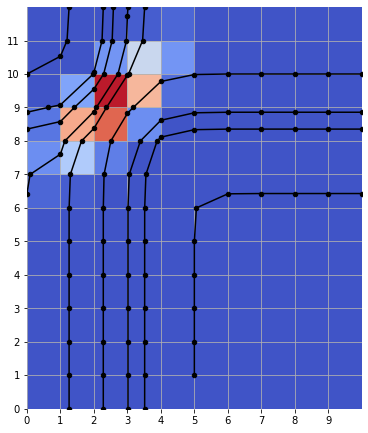

In [79]:
figsize(6,8)
plot_target(probs)
plot_trajectory(np.stack(sampler.trajectory, axis=1))
plt.show()

### convergence

In [80]:
n_tries = 100
n_iterates = 10000
gt_mean = np.sum(probs[:,:,np.newaxis]*np.stack([x_grid,y_grid], axis=2), axis=(0,1))[::-1]
errors = errors_estimate(probs, n_iterates, n_tries)

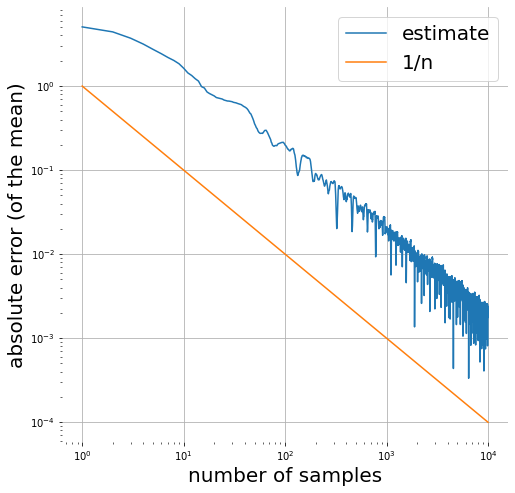

In [81]:
figsize(8,8)
plt.plot(np.arange(1,n_iterates+1), np.mean(errors, axis=0), label='estimate')
plt.plot(np.arange(1,n_iterates+1),1/np.arange(1,n_iterates+1), label='1/n')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of samples', size=20)
plt.ylabel('absolute error (of the mean)', size=20)
plt.legend(fontsize=20)
plt.grid()
plt.box(False)
plt.show()

### target distribution

Finally, let's consider a mixture

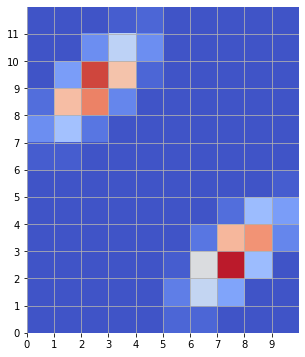

In [82]:
m,n = 10,12
x_grid,y_grid = np.arange(m),np.arange(n)
x_grid,y_grid = np.meshgrid(x_grid,y_grid)
probs = 0.5*stats.multivariate_normal.pdf(np.stack([x_grid,y_grid], axis=2), 
                                      mean = [m/5,n/1.4], cov=[[1.,0.7],[0.7,1.]]) +\
        0.5*stats.multivariate_normal.pdf(np.stack([x_grid,y_grid], axis=2), 
                                          mean = [m/1.4,n/5], cov=[[1.,0.7],[0.7,1.]])
probs /= np.sum(probs)
figsize(6,6)
plot_target(probs)
plt.show()

In [87]:
sampler = CGibbs(probs, np.array([1,5]))

In [88]:
for _ in range(100):
    sampler.iterate()

### 100 iterations (samples)

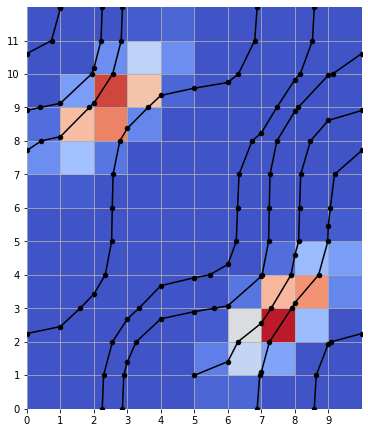

In [89]:
figsize(6,8)
plot_target(probs)
plot_trajectory(np.stack(sampler.trajectory, axis=1))
plt.show()

### convergence

In [90]:
n_tries = 100
n_iterates = 10000
gt_mean = np.sum(probs[:,:,np.newaxis]*np.stack([x_grid,y_grid], axis=2), axis=(0,1))[::-1]
errors = errors_estimate(probs, n_iterates, n_tries)

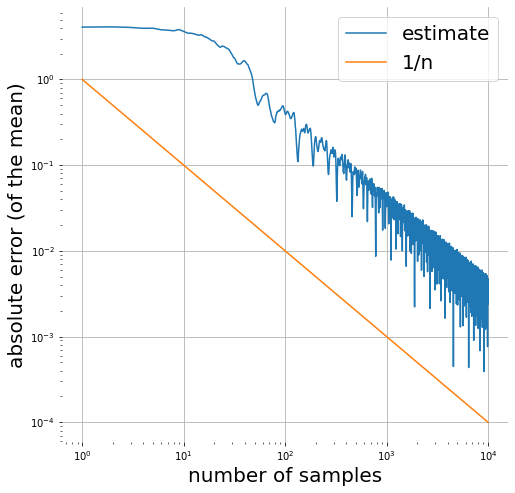

In [91]:
figsize(8,8)
plt.plot(np.arange(1,n_iterates+1), np.mean(errors, axis=0), label='estimate')
plt.plot(np.arange(1,n_iterates+1),1/np.arange(1,n_iterates+1), label='1/n')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of samples', size=20)
plt.ylabel('absolute error (of the mean)', size=20)
plt.legend(fontsize=20)
plt.grid()
plt.box(False)
plt.show()

## Some GIFs

### bimodal gaussian

In [103]:
m,n = 10,12
x_grid,y_grid = np.arange(m),np.arange(n)
x_grid,y_grid = np.meshgrid(x_grid,y_grid)
probs = 0.5*stats.multivariate_normal.pdf(np.stack([x_grid,y_grid], axis=2), 
                                      mean = [m/5,n/1.4], cov=[[1.,0.7],[0.7,1.]]) +\
        0.5*stats.multivariate_normal.pdf(np.stack([x_grid,y_grid], axis=2), 
                                          mean = [m/1.4,n/5], cov=[[1.,0.7],[0.7,1.]])
probs /= np.sum(probs)

sampler = CGibbs(probs, np.array([1,5]))
for _ in range(200):
    sampler.iterate()
trajectory = np.stack(sampler.trajectory, axis=1)

In [130]:
figsize(16,8)
for i in range(1,trajectory.shape[1]):
    plt.subplot(121)
    plot_target(probs)
    plot_trajectory(trajectory[:,max(i-10,0):i])
    plt.subplot(122)
    plot_target(probs)
    plot_trajectory(trajectory[:,:i])
    plt.savefig('./dynamics_gifs/bimodal_gaussian/frame_%0.3d.png' % i, bbox_inches='tight')
    plt.clf()

<Figure size 1152x576 with 0 Axes>

In [129]:
!rm ./dynamics_gifs/bimodal_gaussian/*

In [128]:
!ls ./dynamics_gifs/bimodal_gaussian/

frame_001.png frame_003.png frame_005.png frame_007.png frame_009.png
frame_002.png frame_004.png frame_006.png frame_008.png


In [134]:
!convert -delay 10 -loop 0 ./dynamics_gifs/bimodal_gaussian/*.png bimodal_gaussian.gif

### centered gaussian

In [136]:
m,n = 10,12
x_grid,y_grid = np.arange(m),np.arange(n)
x_grid,y_grid = np.meshgrid(x_grid,y_grid)
probs = stats.multivariate_normal.pdf(np.stack([x_grid,y_grid], axis=2), 
                                          mean = [m/2,n/2], cov=[[1.,0.7],[0.7,1.]])
probs /= np.sum(probs)

sampler = CGibbs(probs, np.array([1,5]))
for _ in range(200):
    sampler.iterate()
trajectory = np.stack(sampler.trajectory, axis=1)

In [135]:
!mkdir ./dynamics_gifs/centered_gaussian

In [137]:
figsize(16,8)
for i in range(1,trajectory.shape[1]):
    plt.subplot(121)
    plot_target(probs)
    plot_trajectory(trajectory[:,max(i-10,0):i])
    plt.subplot(122)
    plot_target(probs)
    plot_trajectory(trajectory[:,:i])
    plt.savefig('./dynamics_gifs/centered_gaussian/frame_%0.3d.png' % i, bbox_inches='tight')
    plt.clf()

<Figure size 1152x576 with 0 Axes>

In [138]:
!convert -delay 10 -loop 0 ./dynamics_gifs/centered_gaussian/*.png ./dynamics_gifs/centered_gaussian.gif